In [17]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from numpy.random import default_rng
import pymc as pm
import arviz as az

# Should you be a Frequentist or a Bayesian

<div>
  <center> 
    <img src="img/FisherBayes.png" style="height:40%;"/>
  </center>
</div>

## A unedited, non exhaustive, and opinionated take

# Whats your situation right now?

# You may be academic doing science!

<div>
  <center> 
    <img src="img/Academic.png" style="height:40%;"/>
  </center>
</div>

# In industry

<div>
  <center> 
    <img src="img/Industry.png" style="height:40%;"/>
  </center>
</div>

# Or you may be running a book club 

## On a book that uses Frequentist Methods

<div>
    <center>
    <img src="https://mixtape.scunning.com/images/cover.jpg" style="height:700px;"/>
    </center>
</div>


## After writing a book on Bayesian Methods
<div>
  <center>
<img src="https://bayesiancomputationbook.com/_images/Cover.jpg" style="height:700px;"/>
  </center>
</div>

Where the book you've picked uses frequentist methods and people are asking you  "I thought you were Bayesian, why would you choose this book?"

# Which should you be

* Frequentist?
* Bayesian?

## Be neither


# Be a data professional


## Learn both

# As a data professional your job is to help people learn new things
You need to
* Know the various ways to do that
* Be able to pick the right tool for the right situation
* Understand what other professionals are doing

# P(right tool | your situation)
* What data is available
* What question you're trying to answer
* What is influential in your community
* Where is there room for improvement
* How the system or process you're using works

# Can only make the choice if you're open to learning

## Not tied to a fixed identity

# Why do I use Bayes method (more)?

## Whats the difference?

In [18]:
mean = 2
sd = 1
sample_size = 8

# rng = default_rng(12345)
np.random.seed(0)
observed_lead_times = stats.norm(mean, sd).rvs(sample_size)

# Imagine you work for a rocket company

<div>
  <center> 
    <img src="img/SpaceXPhoto.jpeg" style="height:800px;"/>
  </center>
</div>

# Gotta get stuff into space

We need this massive rocket part to be completed **in the next 4 days** or this $400 million dollar satellite launch will be delayed.  

</br>

Here's the last 8 delivery lead times from order to arrival.

In [19]:
observed_lead_times

array([3.76405235, 2.40015721, 2.97873798, 4.2408932 , 3.86755799,
       1.02272212, 2.95008842, 1.84864279])

We need the part in 2 days

Are we going to be late?

# Frequentist Analysis

* Long run probabilities
* Make conclusions about groups of events, not single events
* **A typical output**: Confidence intervals

## A quick overview

In [20]:
calculated_mean = observed_lead_times.mean()
calculated_sd  = observed_lead_times.std()
calculated_mean, calculated_sd

(2.884106507142941, 1.022668337083785)

#### Some manual and automated calculations for quantities of interest

In [21]:
### Note: Be careful about implicit degrees of freedom adjustments
observed_lead_times.std(ddof=1) / np.sqrt(sample_size)

0.3865322990890955

In [22]:
stats.sem(observed_lead_times)

0.3865322990890955

## Calculate a 95% CI of the means

In [23]:
ci = stats.norm.interval(alpha=0.95, loc=calculated_mean, scale=stats.sem(observed_lead_times)) 
ci

(2.1265171220668497, 3.6416958922190323)

**Note:** This is NOT the confidence level that the next delivery will be within this interval with 95% chance.

# The fully worded conclusion

If in 100 random hypothetical universes you have 8 more part deliveries, if you take the mean arrival lead time of those deliveries 5 of those means will be over 2 days

### And we're done!

## Empirical Evaluation of Confidence Intervals
1. Make one hundred draws of 8 samples each
2. Calculate the mean of each and interval of each set of samples
3. See where the true value falls

In [24]:
random_draws = stats.norm(mean, sd).rvs((100, sample_size))

In [25]:
calculated_mean = random_draws.mean(axis=1)
calculated_sem = stats.sem(random_draws, axis=1)

In [26]:
ci = np.stack(stats.norm.interval(alpha=0.95, loc=calculated_mean, scale=calculated_sem), axis=1)
ci[:10]

array([[2.11158899, 2.77989777],
       [0.99433842, 2.74835976],
       [1.7077111 , 3.34459179],
       [1.10195903, 2.56876486],
       [0.68355322, 2.40467249],
       [1.0363565 , 2.05702103],
       [1.04885218, 1.90126866],
       [1.28976782, 2.36296958],
       [1.20897305, 2.27029505],
       [1.51965499, 3.24236789]])

## Confidence Interval Plot

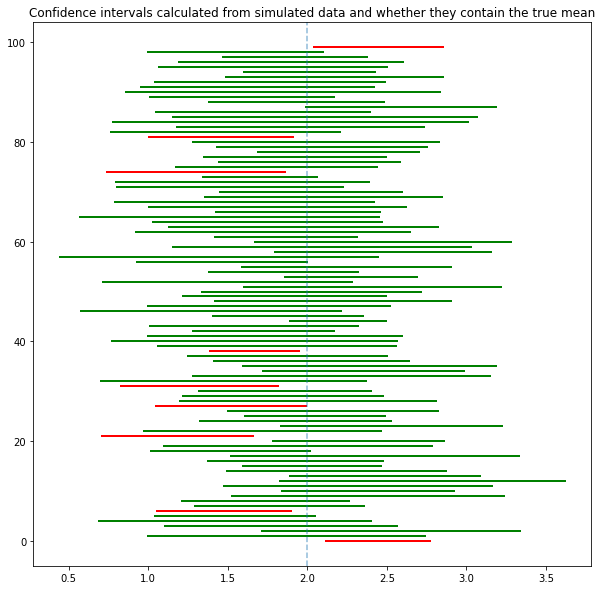

In [27]:
fig, ax = plt.subplots(figsize= (10,10))

for i in range(ci.shape[0]):
    if ci[i,0] <= mean and mean <= ci[i,1] :
        c = "g"
    else:
        c="r"
    ax.hlines(y=i, xmin=ci[i,0], xmax=ci[i,1], linewidth=2, color=c )

ax.set_title("Confidence intervals calculated from simulated data and whether they contain the true mean")
ax.axvline(2, linestyle="--", alpha = .5);

In [28]:
true_mean_in_interval = np.logical_and(ci[:,0] <= mean, ci[:,1] >= mean)
true_mean_in_interval.sum()

91

## References
* https://www.westga.edu/academics/research/vrc/assets/docs/tests_of_significance_notes.pdf
* http://www.stat.yale.edu/Courses/1997-98/101/sigtest.htm

# Bayesian Analysis
* Focuses more on beliefs in parameters
* **A typical output:** Credible Intervals

# Define a Model

In [29]:
with pm.Model() as rocket_lead_time:
    mean_lead_time = pm.Normal("mean_lead_time", 10, 2)
    sd_lead_time = pm.HalfNormal("sd_lead_time", 10)
    lead_times = pm.TruncatedNormal("lead_times", mu=mean_lead_time, 
                                                  sigma=sd_lead_time,
                                                  lower=0,
                                                  observed=observed_lead_times)
    samples = pm.sample(target_accept=.95)
    future_rocket_lead_times = pm.sample_posterior_predictive(samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_lead_time, sd_lead_time]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8896, but should be close to 0.95. Try to increase the number of tuning steps.


# Get predictions for individual future part lead times

In [30]:
future_rocket_lead_times.posterior_predictive.lead_times

<xarray.DataArray 'lead_times' (chain: 4, draw: 1000, lead_times_dim_0: 8)>
array([[[ 7.62423157,  4.9880461 ,  5.70837225, ...,  8.60237027,
          3.6726113 ,  4.88200998],
        [ 7.04222629,  6.51833697,  3.82462982, ...,  7.64390659,
          2.18708706,  1.03802637],
        [ 3.15069898,  3.02008551,  4.10221045, ...,  2.29598531,
          2.05853143,  1.31785331],
        ...,
        [ 5.9385172 ,  4.8367692 ,  3.00187332, ...,  2.09819493,
          5.15380034,  5.57396289],
        [ 3.86439759,  4.63595456,  3.64985741, ...,  4.56544768,
          4.80178861,  3.85927766],
        [ 3.63465812,  2.64699268,  3.47444484, ...,  2.3797755 ,
          4.977463  ,  4.0167255 ]],

       [[ 0.74147614,  4.17573861,  5.575251  , ...,  4.52689058,
          8.70893452,  2.34343565],
        [ 5.13738171, 10.64064122,  2.97637598, ...,  6.979377  ,
          9.18540341,  5.48979935],
        [11.92522516,  9.86375914, 14.16408281, ...,  4.52285692,
         15.98379906,  5.2902552 ],
...
        [ 5.01096564,  1.27982445,  4.63947959, ...,  2.72216361,
          2.03856651,  0.39972319],
        [ 3.04049311,  4.52432611,  2.81064806, ...,  4.09483923,
          4.39039522,  3.28146012],
        [ 0.69286294,  3.83385268,  4.50432791, ...,  4.25372532,
          2.8723098 ,  1.82518659]],

       [[ 2.8312977 ,  0.93227757,  2.62125236, ...,  1.83324813,
          7.47613994,  5.14420552],
        [ 2.00502608,  2.1225971 ,  6.59586094, ...,  1.39069359,
          1.57549499,  5.48104526],
        [ 6.08332641,  4.57255887,  5.24419563, ...,  3.42066927,
          3.26197032,  1.49562295],
        ...,
        [ 3.65100009,  4.60831046,  3.24579628, ...,  3.45037669,
          5.29306678,  3.07465967],
        [ 3.79764278,  4.50165646,  6.34167946, ...,  1.60089401,
          2.5512777 ,  4.54927209],
        [ 4.44755112,  2.61510005,  6.82678196, ...,  3.90602108,
          4.16610004,  2.46364425]]])
Coordinates:
  * chain             (chain) int64 0 1 2 3
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * lead_times_dim_0  (lead_times_dim_0) int64 0 1 2 3 4 5 6 7

# Posterior Predictive Plot

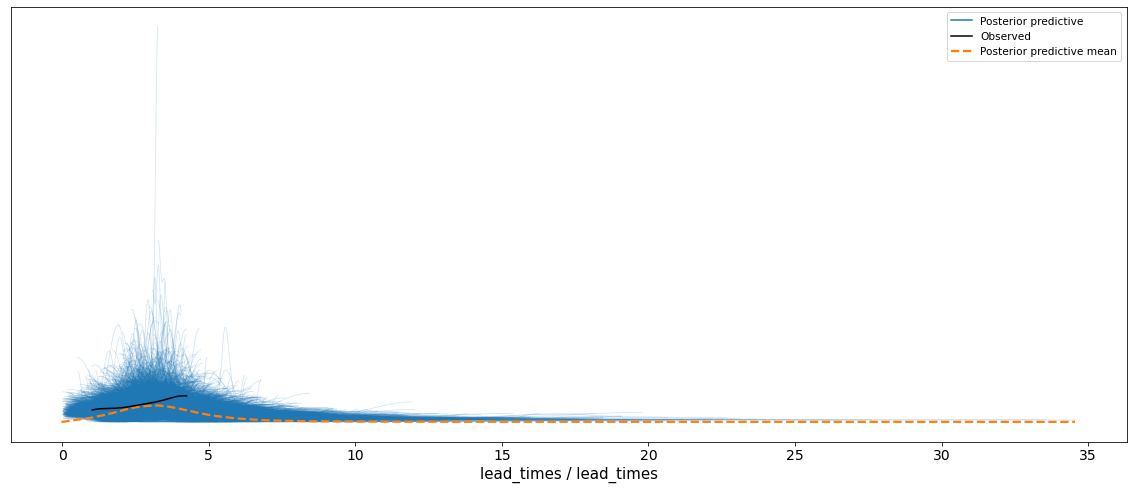

In [31]:
fig, ax = plt.subplots(figsize=(20, 8))
az.plot_ppc(future_rocket_lead_times, ax=ax);

# Credible intervals

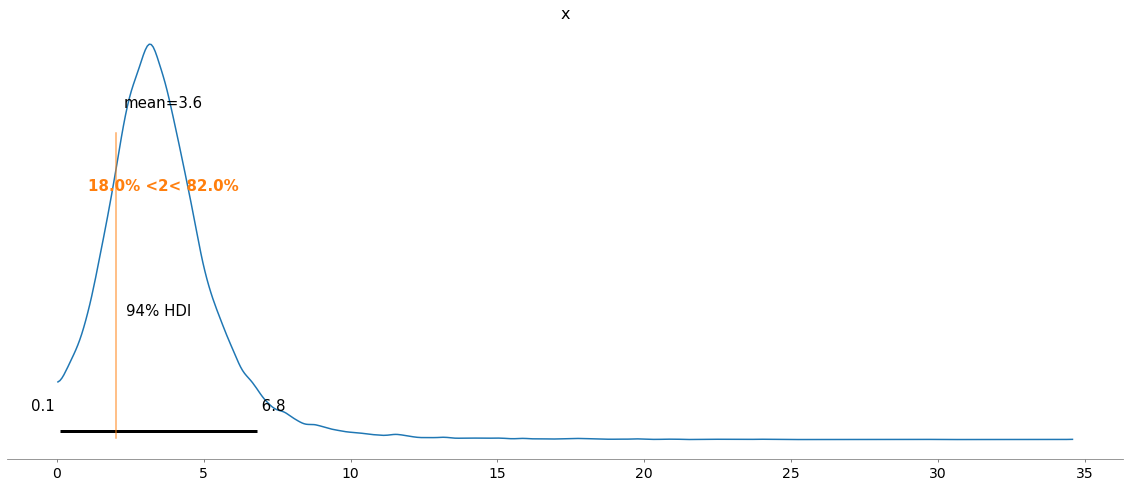

In [32]:
fig, ax = plt.subplots(figsize=(20, 8))
az.plot_posterior(future_rocket_lead_times.posterior_predictive.lead_times.values.reshape(-1), ref_val=2, ax=ax);

# Why Bayes works for my situations


## I personally don't
* Have lot of data
* Do comparative hypothesis testing
  * Like A/B Tests
* Work with experimental data
  * Randomized Controls Trials
  * Constructed Studies
* Work primarily with statisticians 
* Care about groups of data
  * Or the mean of a group

## There is nothing wrong with frequentist analysis

# There's just different Assumptions

**Frequentist**: Fixed parameter, random data, "Frequencies of things"

**Bayesian**: Unknown Parameters, fixed data, "Beliefs of parameters"

# Same goal

<div>
  <center>
    <img src="img/EpicHandshake.jpeg" style="height:700px;"/>
  </center>
</div>

# Same problem

## Education

## Frequentism

Widely taught everywhere, but typically done so poorly
* Usually taught as a formulaic follow these steps with
  * Little critical thinking
  * No advice on how to deviate from steps or develop your own methods
* Often taught using ancient methods
  * Z Score table lookups
* Not explained well in educational institutions
  * Can create early biases in uninformed students
  * *in my experience*

## Bayesianism
Not widely taught, when done so fairly deeply from first principles
* Overly theoretical with lots of math formulas
* Most places stop at point estimate methodology
* Legacy outdated ideas persist here too
  * e.g. conjugate models
  * Obtuse examples like the eight schools model

# Here's some resources

# This book
<div>
  <center>
    <img src="https://images-na.ssl-images-amazon.com/images/I/8123QQADYhL.jpg" style="height:700px;"/>
  </center>
</div>


# This talk
<div>
  <center>
    <img src="img/VanderPlasTalk.png" style="width:1000px;"/>
  </center>
</div>


https://www.youtube.com/embed/KhAUfqhLakw

# Use both both hands on
* Find applied examples
  * Really dig into each
* Use scikit-learn or a PPL to help

* Apply it to your actual problems

# Don't get hung up on an identity


##  Be a data professional


Not a "Frequentist" or a "Bayesian"

* Know the tools that are out there
    * The use cases for each
* Be able to read and understand other peoples work
* Know which technique is appropriate for what place

# You'll stand out from others


* You'll give yourself significant credibility by a wide interval
  * You'll exude confidence in your understanding above 95% percent of others
  
* The whole distribution of jobs, research groups, stats communities will be open to you
  * You'll blow away folks prior beliefs about you
  * They'll certainly have to update their expectations

# If you're part of the book club
We're going to learn both hands on
* Book is written in Frequentist framework so we'll definitely use that
* Will reanalyze some examples in Bayesian framework when it makes sense

# If you want to be part of a book club
Or get other updates

* Follow me on twitter @canyon289
* Join my mailing list
* Check out my blog ravinkumar.com